# Sensitivity Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import collections
import seaborn as sns
import os
from pathlib import Path
import glob
import re
from cycler import cycler
import itertools

import fiona
import geopandas as gp
from shapely.geometry import LineString, Point, Polygon

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


%matplotlib inline

sns.color_palette()

sns.set_style("white", {"xtick.direction": "in","ytick.direction": "in"})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors[:6]) 
my_tiel = (0.4, 0.7607843137254902, 0.6470588235294118) # Recycling
my_orange = (0.9882352941176471, 0.5529411764705883, 0.3843137254901961) # Manufacturing
my_purple = (0.5529411764705883, 0.6274509803921569, 0.796078431372549) # 40209
my_pink = (0.9058823529411765, 0.5411764705882353, 0.7647058823529411) #NAICS

### Setup all file scenarios

The files I am going to load are the ones showed in the table below. This is to know which file correspond to what. I have not added the dates in the file name since they are autogenerated and it is a sanity check for me, but in reality the dates (numbers in front of the file name scenario) don't matter.
![scenarios_info.png](resources/scenarios_info_cost.png)
![scenarios_info_cap.png](resources/scenarios_info_capacity.png)

In [ ]:
cwd = os.getcwd()

In [ ]:
facility_label = ['Manufacturing', 'Recycling','Manufacturing_cap', 'Recycling_cap']
location_label = ['NAICS', '40209']
factor_label_rec = ['05', '1', '2', '5', '10']
factor_label_man = ['05', '1', '2', '5', '10'] # 0 is 0,5

In [ ]:
files_list = []
for fac in facility_label:
    for loc in location_label:
        if fac.startswith('Manufacturing'):
            for fac_man in factor_label_man:
                files_list.append(fac+'_'+loc+'_'+fac_man)
        else:
            for fac_rec in factor_label_rec:
                files_list.append(fac+'_'+loc+'_'+fac_rec) 

In [ ]:
facility_label_both = ['Manufacturing', 'Recycling']
location_label = ['BOTH', 'BOTHS']
discount_yn = ['ND', 'D']
discount_perc = ['10']
factor_label = ['1']
 # add the appropiate discount or a list of discounts, the numbers are in %

In [ ]:
for faci in facility_label_both:
    for loc in location_label:
        for disc in discount_yn:
            if disc.startswith('ND'):
                for fac in factor_label:
                        files_list.append(faci+'_'+loc+'_'+disc+'_'+fac)
            else:
                for perc in discount_perc:
                    for fac in factor_label:
                        files_list.append(faci+'_'+loc+'_'+disc+'_'+perc+'_'+fac) 

#### Group the files into smaller bins for easier handling

In [ ]:
recycling_files = [x for x in files_list if x.startswith('Recycling')]
recycling_files_cap = [x for x in recycling_files if "cap" in x]
recycling_files_cost = [x for x in recycling_files if "cap" not in x]
recycling_files_both_d = [x for x in recycling_files if "BOTH" in x and 'ND' not in x]
recycling_files_both_nd = [x for x in recycling_files if "BOTH" in x and 'ND' in x]


In [ ]:
recycling_files_both_d

In [ ]:
manufacturing_files = [x for x in files_list if x.startswith('Manufacturing')]
manufacturing_files_cap = [x for x in manufacturing_files if "cap" in x]
manufacturing_files_cost = [x for x in manufacturing_files if "cap" not in x]
manufacturing_files_both_d = [x for x in manufacturing_files if "BOTH" in x and 'ND' not in x]
manufacturing_files_both_nd = [x for x in manufacturing_files if "BOTH" in x and 'ND' in x]

#### Dictionary to change year number to actual years

In [ ]:
year_list = list(range(2025, 2051, 1))
number_year = list(range(1, 27, 1))
years_dict = dict(zip(number_year,year_list))


#### Load plant files

In [ ]:
previous_folder = os.path.normpath(os.getcwd() + os.sep + os.pardir) # Get previous folder from current directory

##### Recycling cost

In [ ]:
for files in recycling_files_cost:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'outpput', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))

Some of the manufacturing files have no solution, so we remove them:

##### Manufacturing cost

In [ ]:
manufacturing_files_cost

In [ ]:
for files in manufacturing_files_cost:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))

##### Recycling capacity

In [ ]:
for files in recycling_files_cap:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

##### Manufacturing capacity

In [ ]:
for files in manufacturing_files_cap:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

##### Recycling both NO DISCOUNT

In [22]:
for files in recycling_files_both_nd:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Recycling_BOTH_ND_1: 81 locations
Recycling_BOTHS_ND_1: 84 locations


##### Recycling both DISCOUNT

In [ ]:
for files in recycling_files_both_d:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

##### Manufacturing both NO DISCOUNT

In [23]:
for files in manufacturing_files_both_nd:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Manufacturing_BOTH_ND_1: 62 locations
Manufacturing_BOTHS_ND_1: 62 locations


##### Manufacturing both DISCOUNT

In [ ]:
for files in manufacturing_files_both_d:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

### Selected locations plot

In [36]:
rec_cap_locs_data = [['Capacity', 'Recycling', 'NAICS', 0.5, 161], 
                     ['Capacity', 'Recycling','NAICS',1, 81], 
                     ['Capacity', 'Recycling','NAICS',2, 41],
                     ['Capacity', 'Recycling','NAICS',5, 17],
                     ['Capacity', 'Recycling','NAICS',10, 9],
                     ['Capacity', 'Recycling', '40209', 0.5, 161], 
                     ['Capacity', 'Recycling','40209',1, 81], 
                     ['Capacity', 'Recycling','40209',2, 41],
                     ['Capacity', 'Recycling','40209',5, 17],
                     ['Capacity', 'Recycling','40209',10, 10],
                     ['Cost', 'Recycling', 'NAICS',0.5, 81], 
                     ['Cost', 'Recycling','NAICS',1, 81], 
                     ['Cost', 'Recycling','NAICS',2, 81],
                     ['Cost', 'Recycling','NAICS',5, 81],
                     ['Cost', 'Recycling','NAICS',10, 81],
                     ['Cost', 'Recycling', '40209',0.5, 81], 
                     ['Cost', 'Recycling','40209',1, 81], 
                     ['Cost', 'Recycling','40209',2, 81],
                     ['Cost', 'Recycling','40209',5, 81],
                     ['Cost', 'Recycling','40209',10, 81],
                     ['Both', 'Recycling', 'All', 1, 81],
                     ['Both', 'Recycling', 'Selected', 1, 84],
                     ['Capacity', 'Manufacturing', 'NAICS',0.5, 124],
                     ['Capacity', 'Manufacturing', 'NAICS',1, 62],
                     ['Capacity', 'Manufacturing', 'NAICS',2, 31],
                     ['Capacity', 'Manufacturing', '40209', 0.5, 124],
                     ['Capacity', 'Manufacturing', '40209', 1, 62],
                     ['Capacity', 'Manufacturing', '40209', 2, 31],
                     ['Capacity', 'Manufacturing', '40209', 5, 31],
                     ['Capacity', 'Manufacturing', '40209', 10, 7],
                     # ['Cost', 'Manufacturing', 'NAICS',0.001, 151],
                     ['Cost', 'Manufacturing', 'NAICS',0.5, 62],
                     ['Cost', 'Manufacturing', 'NAICS',1, 62],
                     ['Cost', 'Manufacturing', 'NAICS',2, 62],
                     ['Cost', 'Manufacturing', 'NAICS',5, 62],
                     ['Cost', 'Manufacturing', 'NAICS',10, 62],
                     # ['Cost', 'Manufacturing', '40209',0.001, 143],
                     ['Cost', 'Manufacturing', '40209',0.5, 62],
                     ['Cost', 'Manufacturing', '40209',1, 62],
                     ['Cost', 'Manufacturing', '40209',2, 62],
                     ['Both', 'Manufacturing', 'All', 1, 62], # Changeee
                     ['Both', 'Manufacturing', 'Selected', 1, 62]] 

rec_cap_locs_data_df = pd.DataFrame(rec_cap_locs_data, columns=['Analysis', 'Facility', 'Location group','Factor', 'Selected locations'])

#### Recycling

In [37]:
factors_rec = [0.5, 1, 2, 5, 10]

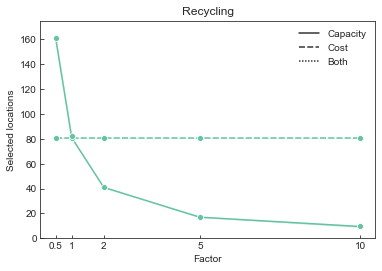

In [38]:
figure = sns.lineplot(x='Factor', y='Selected locations', data=rec_cap_locs_data_df.loc[rec_cap_locs_data_df['Facility'] == 'Recycling'], marker='o', style="Analysis", color=my_tiel)
figure.legend(frameon=False)
figure.set(title='Recycling', ylim = (0, 175))
plt.xticks(factors_rec, labels = factors_rec)
plt.savefig(os.path.join(cwd, f"recycling_selected.png"), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, f"recycling_selected.pdf"), dpi=300);

#### Manufacturing

In [39]:
factors_man = [0.5, 1, 2, 5, 10]

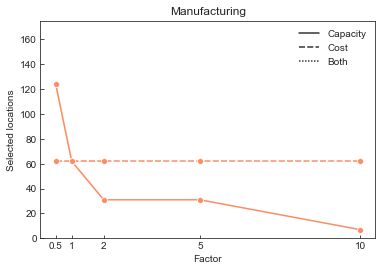

In [40]:
figure = sns.lineplot(x='Factor', y='Selected locations', data=rec_cap_locs_data_df.loc[rec_cap_locs_data_df['Facility'] == 'Manufacturing'], marker='o', style="Analysis", color=my_orange)
figure.legend(frameon=False)
figure.set(title='Manufacturing', ylim = (0, 175))
plt.xticks(factors_man, labels = factors_man)
plt.savefig(os.path.join(cwd, f"manufacturing_selected.png"), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, f"manufacturing_selected.pdf"), dpi=300);

### Map plots

In [ ]:
for files in recycling_files_cost:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_26_years", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Recycling capacity

In [ ]:
for files in recycling_files_cap:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_26_years", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Recycling both NO DISCOUNT

In [ ]:
for files in recycling_files_both_nd:
    testfile_path = glob.glob(os.path.join(previous_folder, "simulations", files,'output', 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Recycling both DISCOUNT

In [ ]:
for files in recycling_files_both_d:
    testfile_path = glob.glob(os.path.join(previous_folder, "simulations", files,'output', 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Manufacturing cost

In [ ]:
for files in manufacturing_files_cost:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_26_years", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Manufacturing capacity

In [ ]:
for files in manufacturing_files_cap:
    testfile_path = glob.glob(os.path.join(cwd, "scenarios_26_years", files, 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Manufacturing both NO DISCOUNT

In [ ]:
for files in manufacturing_files_both_nd:
    testfile_path = glob.glob(os.path.join(previous_folder, "simulations", files,'output', 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

##### Manufacturing both DISCOUNT

In [ ]:
for files in manufacturing_files_both_d:
    testfile_path = glob.glob(os.path.join(previous_folder, "simulations", files,'output', 'transportation.csv'))[0]
    globals()['%s_transportation' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_transportation' % (files)] = globals()['%s_transportation' % (files)].replace({"year": years_dict})

#### Recycling both maps no discount

In [77]:
unique_Recycling_BOTH_ND_1_plants = Recycling_BOTH_ND_1_plants.loc[Recycling_BOTH_ND_1_plants['year'] == 2025].reset_index()
unique_Manufacturing_BOTH_ND_1_plants = Manufacturing_BOTH_ND_1_plants.loc[Manufacturing_BOTH_ND_1_plants['year'] == 2025].reset_index()
unique_Recycling_BOTHS_ND_1_plants = Recycling_BOTHS_ND_1_plants.loc[Recycling_BOTHS_ND_1_plants['year'] == 2025].reset_index()
unique_Manufacturing_BOTHS_ND_1_plants = Manufacturing_BOTHS_ND_1_plants.loc[Manufacturing_BOTHS_ND_1_plants['year'] == 2025].reset_index()

NAICS locations have two capital letters as the state indicator. I will use it to identify whether a location is NAICS or 40209

In [78]:
both_total_NAICS = 309
both_total_40209 = 268

In [79]:
tot_NAICS = 0
tot_40209 = 0
for locations in unique_Recycling_BOTH_ND_1_plants['location name']:
    if locations[-2:].isupper():
        tot_NAICS += 1
    else:
        tot_40209 += 1
        
print('There are {} NAICS locations.'.format(tot_NAICS))
print('There are {} 40209 locations.'.format(tot_40209))

There are 50 NAICS locations.
There are 31 40209 locations.


In [80]:
tot_NAICS = 0
tot_40209 = 0
for locations in unique_Recycling_BOTHS_ND_1_plants['location name']:
    if locations[-2:].isupper():
        tot_NAICS += 1
    else:
        tot_40209 += 1
        
print('There are {} NAICS locations.'.format(tot_NAICS))
print('There are {} 40209 locations.'.format(tot_40209))

There are 54 NAICS locations.
There are 30 40209 locations.


In [81]:
tot_NAICS = 0
tot_40209 = 0
for locations in unique_Manufacturing_BOTH_ND_1_plants['location name']:
    if locations[-2:].isupper():
        tot_NAICS += 1
    else:
        tot_40209 += 1
        
print('There are {} NAICS locations.'.format(tot_NAICS))
print('There are {} 40209 locations.'.format(tot_40209))

There are 38 NAICS locations.
There are 24 40209 locations.


In [82]:
tot_NAICS = 0
tot_40209 = 0
for locations in unique_Manufacturing_BOTHS_ND_1_plants['location name']:
    if locations[-2:].isupper():
        tot_NAICS += 1
    else:
        tot_40209 += 1
        
print('There are {} NAICS locations.'.format(tot_NAICS))
print('There are {} 40209 locations.'.format(tot_40209))

There are 38 NAICS locations.
There are 24 40209 locations.


In [217]:
def get_unique_and_sort(df):
    location_type = []
    unique_sorted_df = df.loc[df['year'] == 2025].reset_index()
    for locations in unique_sorted_df['location name']:
        if locations[-2:].isupper():
            location_type.append('NAICS')
        else:
            location_type.append('40209')
    unique_sorted_df['location type'] = location_type
    return unique_sorted_df

In [203]:
df['location type'].value_counts()

location type
NAICS    54
40209    30
Name: count, dtype: int64

In [ ]:
get_unique_and_sort

In [227]:
def naics_40209_map(df, title):
    df = get_unique_and_sort(df)
    fig = plt.figure(figsize=(10,6))

    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(),
                      frameon=False)
    ax.patch.set_visible(False)

    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    states_shp = os.path.join('resources', 'ne_110m_admin_1_states_provinces_lakes' ,'ne_110m_admin_1_states_provinces_lakes.shp')
    ax.set_title(title)

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.859375)
        return {'facecolor': facecolor, 'edgecolor': 'white'}

    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        styler=colorize_state,
        zorder=1)
    location_colors = {'NAICS':'blue', '40209':'red'}
    ax.scatter(
        x=df['longitude (deg)'],
        y=df['latitude (deg)'],
        #color="red",
        s=40,
        c=df['location type'].map(location_colors),
        alpha=0.5,
        zorder = 2,
        transform=ccrs.PlateCarree()
    )
    col_NAICS = mpatches.Circle((0, 0), 1, facecolor="red")
    col_40209 = mpatches.Circle((0, 0), 1, facecolor="blue")
    labels = ['NAICS locations: {}'.format(df['location type'].value_counts()[0]),
              '40209 locations: {}'.format(df['location type'].value_counts()[1])]
    ax.legend([col_40209,col_NAICS], labels,
              loc='lower left', bbox_to_anchor=(0.2, 0.1), frameon=False)

    return plt.show()


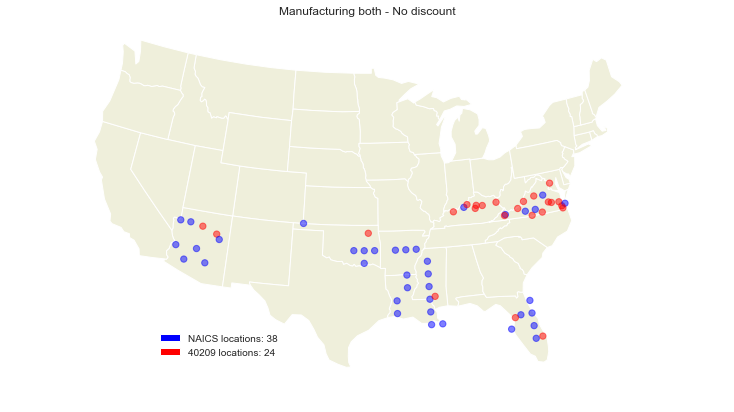

In [228]:
naics_40209_map(Manufacturing_BOTH_ND_1_plants, 'Manufacturing both - No discount')

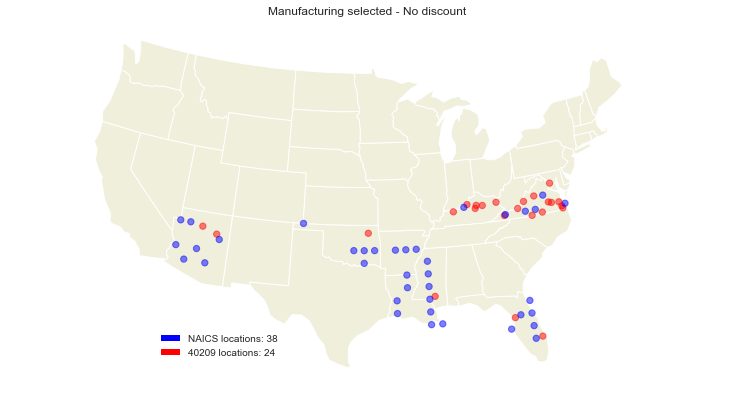

In [229]:
naics_40209_map(Manufacturing_BOTHS_ND_1_plants, 'Manufacturing selected - No discount')

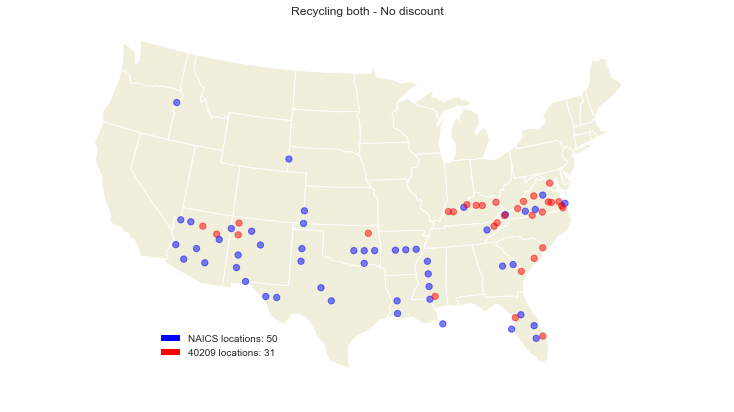

In [231]:
naics_40209_map(Recycling_BOTH_ND_1_plants, 'Recycling both - No discount')

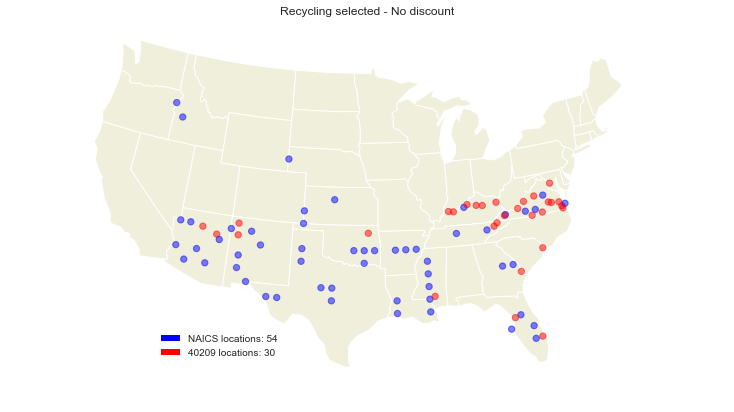

In [232]:
naics_40209_map(Recycling_BOTHS_ND_1_plants, 'Recycling selected - No discount')